In [1]:
%matplotlib inline
import numpy as np
from numpy import random
import newick

In [2]:
# dimensionality reduction and visualization
import anndata as ad
from scanpy.api.tl import diffmap
import matplotlib.pyplot as plt

# make sure to use viridis as the default color map
import matplotlib as mpl

In [3]:
from prosstt import tree
from prosstt import simulation as sim
from prosstt import sim_utils as sut

In [4]:
# set random seed
rseed = 0
random.seed(rseed)

make a tree with longer branches and simulate the average gene expression values

In [6]:
newick1 = "(A:70,B:70)C:70;"
tree1 = newick.loads(newick1)
G = 500
lineage = tree.Tree.from_newick(newick1, genes=G)

uMs, Ws, Hs = sim.simulate_lineage(lineage, a=0.05)
gene_scale = sut.simulate_base_gene_exp(lineage, uMs)
lineage.add_genes(uMs, gene_scale)

/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


sample the whole tree

In [7]:
alpha1 = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=lineage.G))
beta1 = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=lineage.G)) + 1

X1, labs1, brns1, scalings1 = sim.sample_whole_tree(lineage, 1, alpha=alpha1, beta=beta1)

# normalize gene expression by library size
X1 = (X1.transpose() / scalings1).transpose()

sample the beginning, middle, and end of the tree, as if it was a time series experiment
with 3 sample points (one at beginning of differentiation, one around the cell fate
decision point and one when it is certain that the cells have reached their end fates)

In [8]:
X2, labs2, brns2, scalings2 = sim.sample_pseudotime_series(lineage, cells=100,
                                                           series_points=[0, 70, 140],
                                                           point_std=[2, 5, 2],
                                                           alpha=alpha1, beta=beta1)

X2 = (X2.transpose() / scalings2).transpose()

plot the histogram of the sampled times

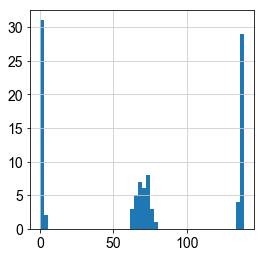

In [9]:
fig, ax = plt.subplots()
h = ax.hist(labs2, bins=50)

calculate the diffusion maps of both samples...

In [10]:
data1 = ad.AnnData(X1)
diffmap(adata=data1)
dm1 = data1.obsm["X_diffmap"]
br_names1, indices1 = np.unique(brns1, return_inverse=True)

data2 = ad.AnnData(X2)
diffmap(adata=data2)
dm2 = data2.obsm["X_diffmap"]
br_names2, indices2 = np.unique(brns2, return_inverse=True)

plot the diffusion maps (branch assignment on the left, pseudotime on the right)

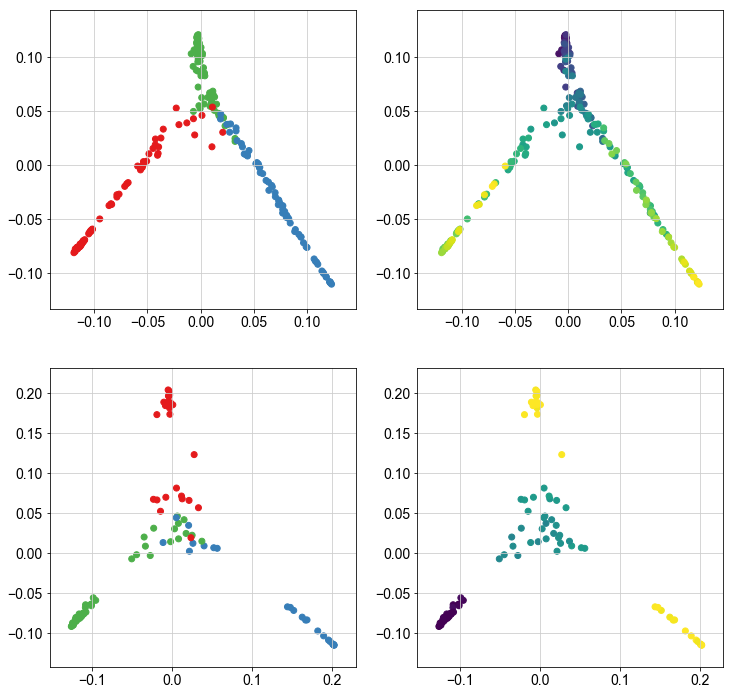

In [11]:
fig, ax = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(w=12, h=12)
# mpl.rcParams['image.cmap'] = 'Set1'
cmap = plt.cm.get_cmap("Set1")
ax[0][0].scatter(dm1[:, 0], dm1[:, 1], c=cmap(indices1))
ax[1][0].scatter(dm2[:, 0], dm2[:, 1], c=cmap(indices2))

mpl.rcParams['image.cmap'] = 'viridis'
ax[0][1].scatter(dm1[:, 0], dm1[:, 1], c=labs1)
ax[1][1].scatter(dm2[:, 0], dm2[:, 1], c=labs2)

While the overall tree structure is preserved, there are gaps between the sample points where there are missing cells.